# Unsupervised Learning Trading Strategy

Steps:
* Download/Load SP500 stocks prices data.
* Calculate different features and indicators on each stock.
* Aggregate on monthly level and filter top 150 most liquid stocks.
* Calculate Monthly Returns for different time-horizons.
* Download Fama-French Factors and Calculate Rolling Factor Betas.
* For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.
* Visualize Portfolio returns and compare to SP500 returns.

### Packages:
* pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

## 1. Download/Load SP500 stocks prices data.

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')



/home/msjithin/Quant_sandbox/.quant/lib/python3.9/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
# Fetch SnP500 stocks
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')

symbols_list = sp500['Symbol'].unique().tolist()

end_date = '2024-01-31'

In [3]:
# Fetch stock prices
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*5)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df.head()

[*********************100%%**********************]  503 of 503 completed


Price              adj close      close       high        low       open  \
date       ticker                                                          
2019-02-01 A       73.368027  76.040001  76.589996  75.620003  76.160004   
           AAL     35.535397  36.110001  36.590000  35.770000  35.770000   
           AAPL    39.906002  41.630001  42.244999  41.482498  41.740002   
           ABBV    63.905811  80.500000  80.730003  79.110001  80.250000   
           ABT     66.525215  72.360001  73.239998  71.970001  73.019997   

Price                   volume  
date       ticker               
2019-02-01 A         1343900.0  
           AAL       6611900.0  
           AAPL    130672400.0  
           ABBV      6759500.0  
           ABT       5016500.0

## 2. Calculate features and technical indicators for each stock.

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [4]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-02-01 A        73.368027   76.040001   76.589996   75.620003   76.160004   
           AAL      35.535397   36.110001   36.590000   35.770000   35.770000   
           AAPL     39.906002   41.630001   42.244999   41.482498   41.740002   
           ABBV     63.905811   80.500000   80.730003   79.110001   80.250000   
           ABT      66.525215   72.360001   73.239998   71.970001   73.019997   
...                       ...         ...         ...         ...         ...   
2024-01-30 YUM     129.969559  130.619995  131.220001  129.580002  130.360001   
           ZBH     122.370003  122.370003  123.199997  121.900002  122.870003   
           ZBRA    250.910004  250.910004  255.979996  250.559998  255.979996   
           ZION     43.976845   44.439999   45.029999   44.389999   44.759998   
           ZTS     191.429993  191.429993  193.509995  190.440002  192.869995   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2019-02-01 A         1343900.0         -0.000458        NaN       NaN   
           AAL       6611900.0          0.000240        NaN       NaN   
           AAPL    130672400.0         -0.000614        NaN       NaN   
           ABBV      6759500.0         -0.019829        NaN       NaN   
           ABT       5016500.0         -0.003199        NaN       NaN   
...                        ...               ...        ...       ...   
2024-01-30 YUM       1421500.0          0.000076  54.698911  4.851065   
           ZBH       1448600.0          0.000050  57.938595  4.794589   
           ZBRA       302100.0          0.000074  50.189867  5.492205   
           ZION      1918900.0         -0.000018  58.434738  3.717250   
           ZTS       1607500.0          0.000106  52.429440  5.229789   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2019-02-01 A            NaN       NaN       NaN       NaN      98.599291  
           AAL          NaN       NaN       NaN       NaN     234.956489  
           AAPL         NaN       NaN       NaN       NaN    5214.613062  
           ABBV         NaN       NaN       NaN       NaN     431.971332  
           ABT          NaN       NaN       NaN       NaN     333.723742  
...                     ...       ...       ...       ...            ...  
2024-01-30 YUM     4.867812  4.884560 -0.503277  0.174845     184.751728  
           ZBH     4.812045  4.829501 -1.032650  0.355011     177.265186  
           ZBRA    5.538067  5.583930 -0.784018  0.002710      75.799912  
           ZION    3.776835  3.836419 -0.186486  0.620221      84.387167  
           ZTS     5.265431  5.301072  0.043214 -0.205429     307.723713  

[627033 rows x 14 columns]

## 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [5]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2019-03-31 A          120.635219   77.555504 -1.563071  4.383309  4.334463   
           AAL        228.367168   31.339825  0.191592  3.526400  3.416201   
           AAPL      5503.300677   45.716156 -1.640628  3.880586  3.741032   
           ABBV       386.059657   63.977253 -1.259878  4.189398  4.135306   
           ABT        412.643482   73.494011 -1.349503  4.319757  4.270157   
...                          ...         ...       ...       ...       ...   
2024-01-31 YUM        195.110404  129.969559 -0.503277  4.884560  4.851065   
           ZBH        200.240083  122.370003 -1.032650  4.829501  4.794589   
           ZBRA        99.249124  250.910004 -0.784018  5.583930  5.492205   
           ZION       106.153491   43.976845 -0.186486  3.836419  3.717250   
           ZTS        358.279310  191.429993  0.043214  5.301072  5.229789   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2019-03-31 A       4.358886         -0.000381  0.099285  54.960629  
           AAL     3.471300          0.000545 -1.418159  42.223409  
           AAPL    3.810809         -0.000507  0.094290  66.474348  
           ABBV    4.162352         -0.019401 -0.232805  53.021764  
           ABT     4.294957         -0.002605  0.501045  63.349618  
...                     ...               ...       ...        ...  
2024-01-31 YUM     4.867812          0.000076  0.174845  54.698911  
           ZBH     4.812045          0.000050  0.355011  57.938595  
           ZBRA    5.538067          0.000074  0.002710  50.189867  
           ZION    3.776835         -0.000018  0.620221  58.434738  
           ZTS     5.265431          0.000106 -0.205429  52.429440  

[29431 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [6]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2020-02-29 AAPL     66.651978 -0.316891  4.448242  4.232049  4.340146   
           ABBV     71.975410  0.248073  4.450873  4.234344  4.342609   
           ABT      71.965279 -0.174030  4.491531  4.317090  4.404311   
           ACN     170.531387 -0.280958  5.375881  5.185128  5.280504   
           ADBE    345.119995 -0.433217  5.971017  5.832036  5.901527   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    446.079987  0.693992  6.108146  6.016643  6.062395   
           VZ       42.470001 -0.016228  3.784167  3.636078  3.710123   
           WFC      50.832954 -0.740943  3.954491  3.852935  3.903713   
           WMT      55.196667 -0.526700  4.031361  3.974779  4.003070   
           XOM     103.884529 -0.135368  4.657573  4.557973  4.607773   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2020-02-29 AAPL            0.002909 -1.006690  34.635063  
           ABBV           -0.006350 -0.175234  43.432024  
           ABT            -0.000368 -1.449725  26.562250  
           ACN            -0.000218 -1.184317  24.475465  
           ADBE            0.000579 -0.162711  45.805770  
...                             ...       ...        ...  
2024-01-31 VRTX            0.000388  2.179932  71.134390  
           VZ              0.000127  2.626460  69.111263  
           WFC             0.000075  0.731412  66.781185  
           WMT             0.000077  1.002431  63.616809  
           XOM             0.000282  0.039460  59.664541  

[7152 rows x 8 columns]

## 4. Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [7]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2021-02-28 AAPL    119.181572  0.613973  4.945365  4.792076  4.868721   
           ABBV     95.312904 -0.003951  4.585832  4.512695  4.549264   
           ABT     113.643951  0.525992  4.815138  4.729650  4.772394   
           ACN     240.621002 -0.238248  5.535537  5.464149  5.499843   
           ADBE    459.670013  0.081894  6.237516  6.122942  6.180229   
...                       ...       ...       ...       ...       ...   
2024-01-31 VRTX    446.079987  0.693992  6.108146  6.016643  6.062395   
           VZ       42.470001 -0.016228  3.784167  3.636078  3.710123   
           WFC      50.832954 -0.740943  3.954491  3.852935  3.903713   
           WMT      55.196667 -0.526700  4.031361  3.974779  4.003070   
           XOM     103.884529 -0.135368  4.657573  4.557973  4.607773   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2021-02-28 AAPL            0.000133 -1.380713  36.515099  -0.079712   
           ABBV           -0.005296 -0.133660  54.185333   0.051327   
           ABT            -0.001782  0.919035  51.778682  -0.030828   
           ACN            -0.001058 -0.198468  47.047028   0.037120   
           ADBE            0.000282 -0.502193  41.726510   0.001962   
...                             ...       ...        ...        ...   
2024-01-31 VRTX            0.000388  2.179932  71.134390   0.096316   
           VZ              0.000127  2.626460  69.111263   0.136840   
           WFC             0.000075  0.731412  66.781185   0.040024   
           WMT             0.000077  1.002431  63.616809   0.050365   
           XOM             0.000282  0.039460  59.664541   0.048710   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2021-02-28 AAPL    -0.043326   0.006651  -0.009780   0.048633    0.049622  
           ABBV     0.008596   0.013894   0.024107   0.021104    0.023679  
           ABT      0.048040   0.035796   0.016358   0.027464    0.038454  
           ACN     -0.018261   0.003557   0.008709   0.025845    0.029108  
           ADBE    -0.041293  -0.013273  -0.018253   0.019422    0.024172  
...                      ...        ...        ...        ...         ...  
2024-01-31 VRTX     0.121265   0.071990   0.040100   0.030387    0.027243  
           VZ       0.061458   0.068601   0.039397   0.016188    0.007815  
           WFC      0.071455   0.091008   0.020218   0.031301    0.009965  
           WMT      0.037076   0.008172   0.009556   0.014065    0.015637  
           XOM      0.010216  -0.000130  -0.000878  -0.010514   -0.005573  

[5143 rows x 14 columns]

## 5. Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [8]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2021')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0278  0.0454  0.0715  0.0039 -0.0194  -0.079712
           ABBV    0.0278  0.0454  0.0715  0.0039 -0.0194   0.051327
           ABT     0.0278  0.0454  0.0715  0.0039 -0.0194  -0.030828
           ACN     0.0278  0.0454  0.0715  0.0039 -0.0194   0.037120
           ADBE    0.0278  0.0454  0.0715  0.0039 -0.0194   0.001962
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.023956
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[4996 rows x 6 columns]

* Filter out stocks with less than 10 months of data.

In [9]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2021-02-28 AAPL    0.0278  0.0454  0.0715  0.0039 -0.0194  -0.079712
           ABBV    0.0278  0.0454  0.0715  0.0039 -0.0194   0.051327
           ABT     0.0278  0.0454  0.0715  0.0039 -0.0194  -0.030828
           ACN     0.0278  0.0454  0.0715  0.0039 -0.0194   0.037120
           ADBE    0.0278  0.0454  0.0715  0.0039 -0.0194   0.001962
...                   ...     ...     ...     ...     ...        ...
2023-12-31 VRTX    0.0485  0.0732  0.0494 -0.0307  0.0132   0.146783
           VZ      0.0485  0.0732  0.0494 -0.0307  0.0132  -0.016436
           WFC     0.0485  0.0732  0.0494 -0.0307  0.0132   0.103835
           WMT     0.0485  0.0732  0.0494 -0.0307  0.0132   0.023956
           XOM     0.0485  0.0732  0.0494 -0.0307  0.0132  -0.026864

[4946 rows x 6 columns]

* Calculate Rolling Factor Betas.

In [10]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2021-02-28 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-12-31 VRTX    0.360415  0.009107 -0.291635 -0.024355  0.716337
           VZ      0.441170 -0.657983  0.528994  0.180236 -0.221705
           WFC     1.028876  0.200397  1.979783 -0.295542 -1.477349
           WMT     0.517328  0.162735 -0.753292  0.591337  0.830256
           XOM     0.743990 -0.459207  1.070072  0.535153  0.320028

[4946 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.

In [11]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4885 entries, (Timestamp('2021-02-28 00:00:00', freq='M'), 'AAPL') to (Timestamp('2024-01-31 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               4885 non-null   float64
 1   bb_high           4885 non-null   float64
 2   bb_low            4885 non-null   float64
 3   bb_mid            4885 non-null   float64
 4   garman_klass_vol  4885 non-null   float64
 5   macd              4885 non-null   float64
 6   rsi               4885 non-null   float64
 7   return_1m         4885 non-null   float64
 8   return_2m         4885 non-null   float64
 9   return_3m         4885 non-null   float64
 10  return_6m         4885 non-null   float64
 11  return_9m         4885 non-null   float64
 12  return_12m        4885 non-null   float64
 13  Mkt-RF            4885 non-null   float64
 14  SMB               4885 non-null   floa

### At this point we have to decide on what ML model and approach to use for predictions etc.


## 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [12]:
# Apply pre-defined centroids.
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [13]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2021-02-28 AAPL    0.613973  4.945365  4.792076  4.868721          0.000133   
           ABBV   -0.003951  4.585832  4.512695  4.549264         -0.005296   
           ABT     0.525992  4.815138  4.729650  4.772394         -0.001782   
           ACN    -0.238248  5.535537  5.464149  5.499843         -0.001058   
           ADBE    0.081894  6.237516  6.122942  6.180229          0.000282   
...                     ...       ...       ...       ...               ...   
2024-01-31 VRTX    0.693992  6.108146  6.016643  6.062395          0.000388   
           VZ     -0.016228  3.784167  3.636078  3.710123          0.000127   
           WFC    -0.740943  3.954491  3.852935  3.903713          0.000075   
           WMT    -0.526700  4.031361  3.974779  4.003070          0.000077   
           XOM    -0.135368  4.657573  4.557973  4.607773          0.000282   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2021-02-28 AAPL   -1.380713  36.515099  -0.079712  -0.043326   0.006651   
           ABBV   -0.133660  54.185333   0.051327   0.008596   0.013894   
           ABT     0.919035  51.778682  -0.030828   0.048040   0.035796   
           ACN    -0.198468  47.047028   0.037120  -0.018261   0.003557   
           ADBE   -0.502193  41.726510   0.001962  -0.041293  -0.013273   
...                     ...        ...        ...        ...        ...   
2024-01-31 VRTX    2.179932  71.134390   0.096316   0.121265   0.071990   
           VZ      2.626460  69.111263   0.136840   0.061458   0.068601   
           WFC     0.731412  66.781185   0.040024   0.071455   0.091008   
           WMT     1.002431  63.616809   0.050365   0.037076   0.008172   
           XOM     0.039460  59.664541   0.048710   0.010216  -0.000130   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2021-02-28 AAPL    -0.009780   0.048633    0.049622  1.200897 -0.285139   
           ABBV     0.024107   0.021104    0.023679  0.414377 -0.087768   
           ABT      0.016358   0.027464    0.038454  0.696897  0.002139   
           ACN      0.008709   0.025845    0.029108  1.266479 -0.341646   
           ADBE    -0.018253   0.019422    0.024172  1.620697 -0.964802   
...                      ...        ...         ...       ...       ...   
2024-01-31 VRTX     0.040100   0.030387    0.027243  0.421371 -0.424384   
           VZ       0.039397   0.016188    0.007815  0.344904 -0.163416   
           WFC      0.020218   0.031301    0.009965  1.123165  0.114385   
           WMT      0.009556   0.014065    0.015637  0.713786 -0.290179   
           XOM     -0.000878  -0.010514   -0.005573  1.017385 -0.451520   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2021-02-28 AAPL   -0.259759  0.167084 -0.113704        0  
           ABBV   -0.409855  0.494596  1.041458        2  
           ABT    -0.290498  0.571517  0.632365        2  
           ACN    -0.287210  0.455551 -0.003565        1  
           ADBE    0.113548  0.074578 -0.450712        1  
...                     ...       ...       ...      ...  
2024-01-31 VRTX   -0.353551  0.053344  0.784898        3  
           VZ      0.314719  0.214516  0.062670        3  
           WFC     1.984496 -0.368755 -1.557082        3  
           WMT    -0.434165 -0.109467  0.586888        2  
           XOM     1.363505 -0.800584  0.174967        2  

[4885 rows x 19 columns]

In [14]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


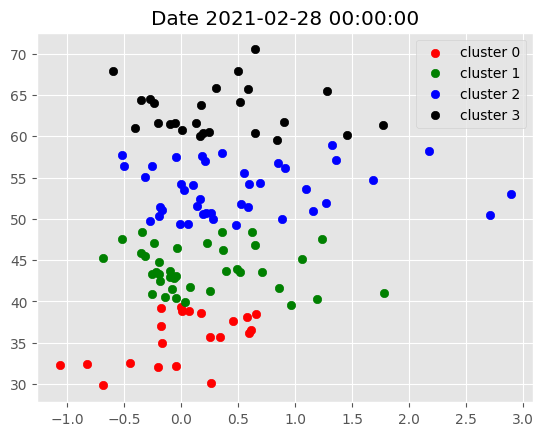

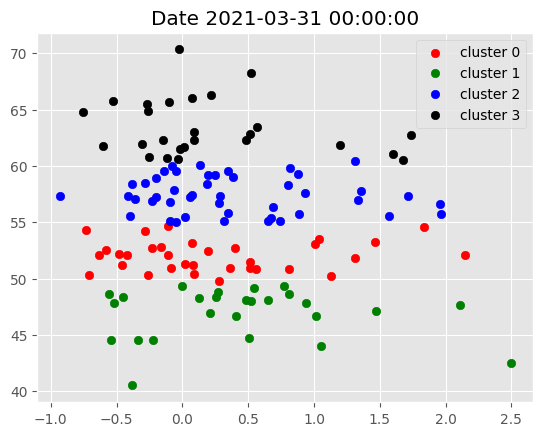

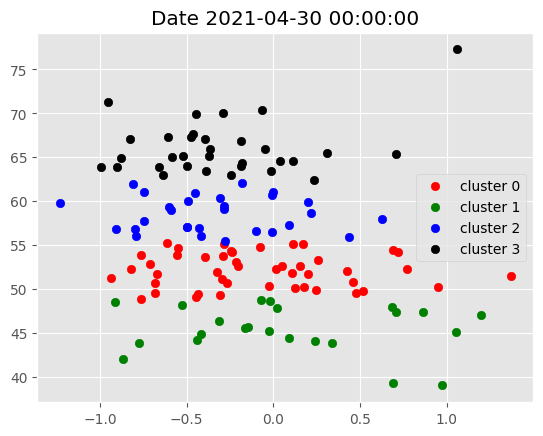

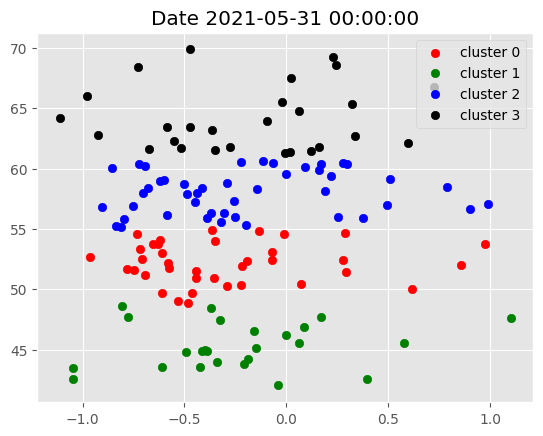

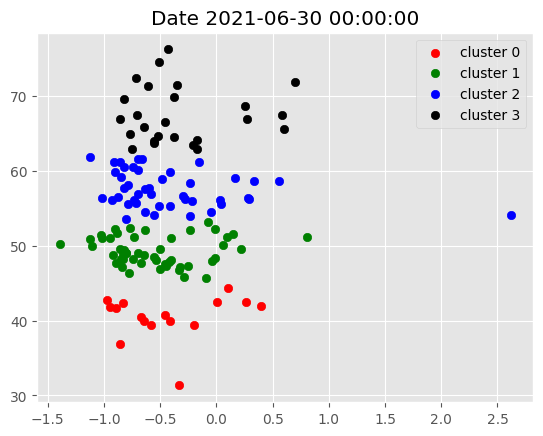

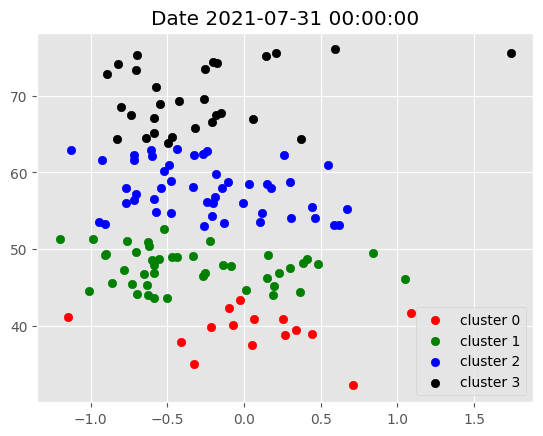

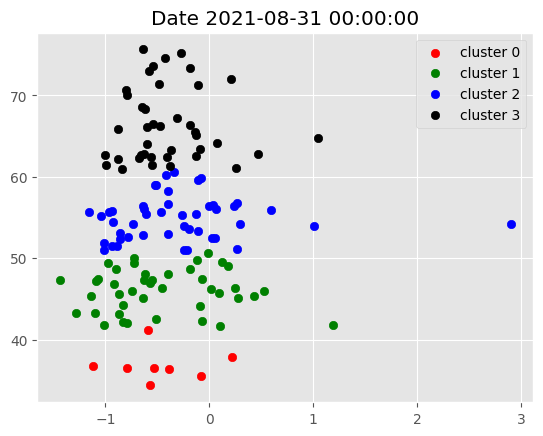

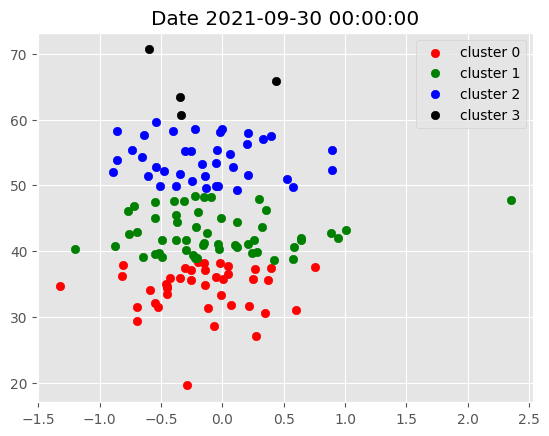

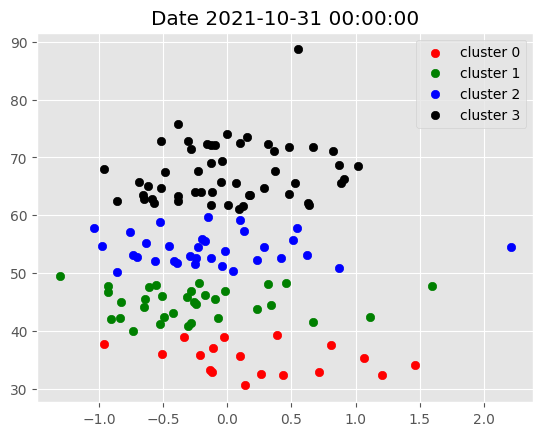

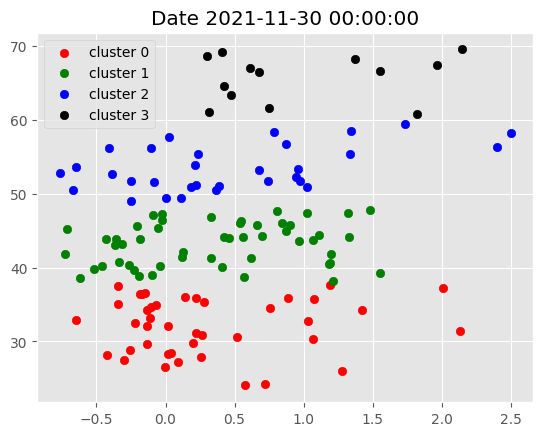

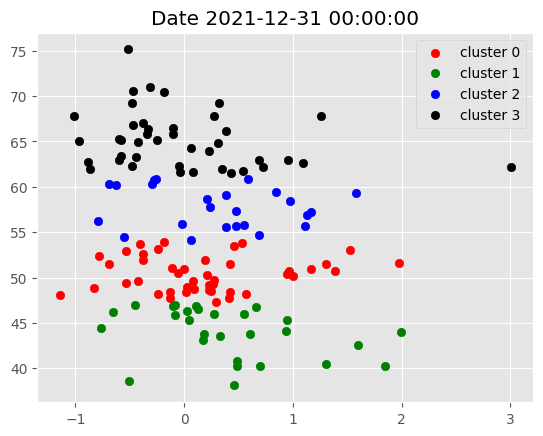

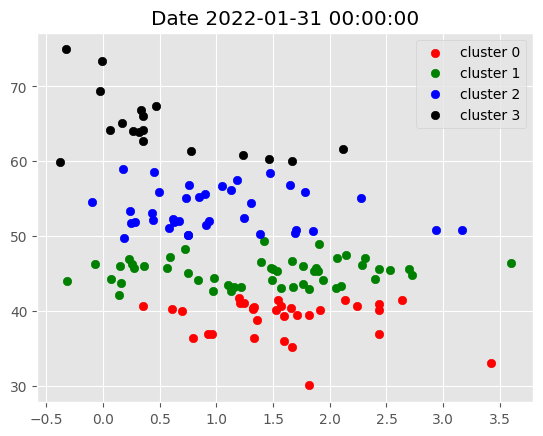

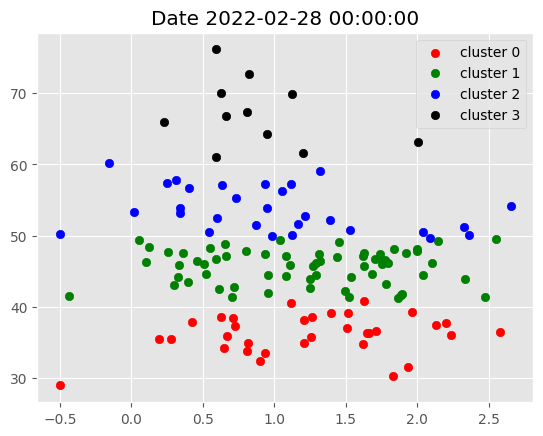

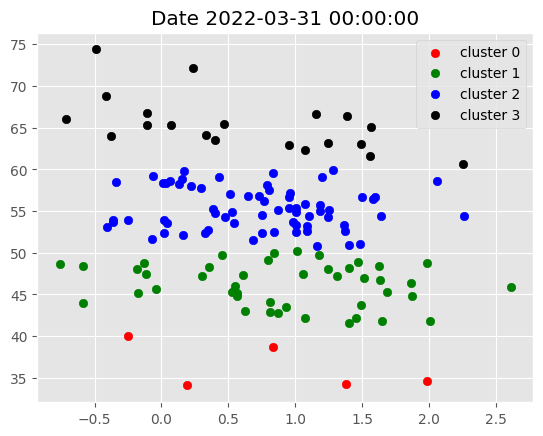

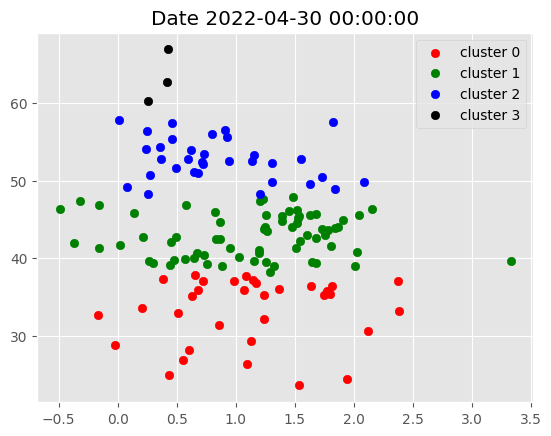

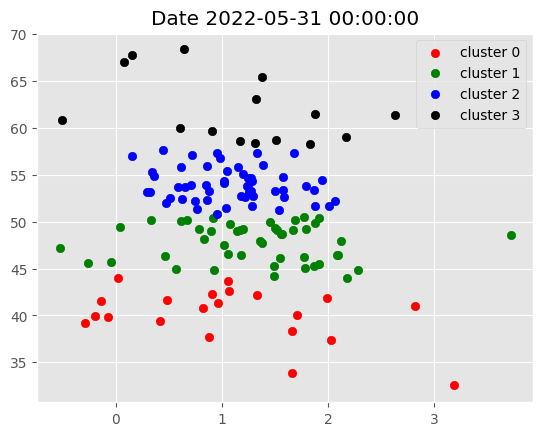

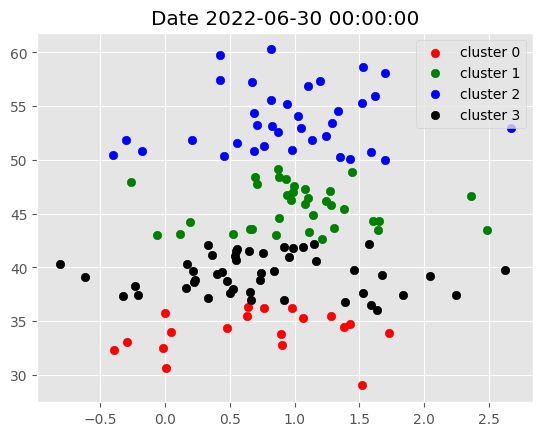

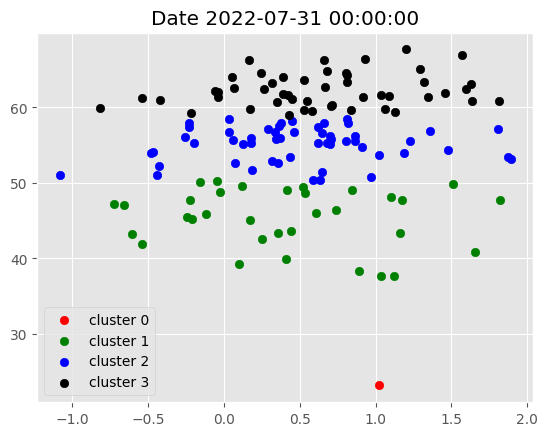

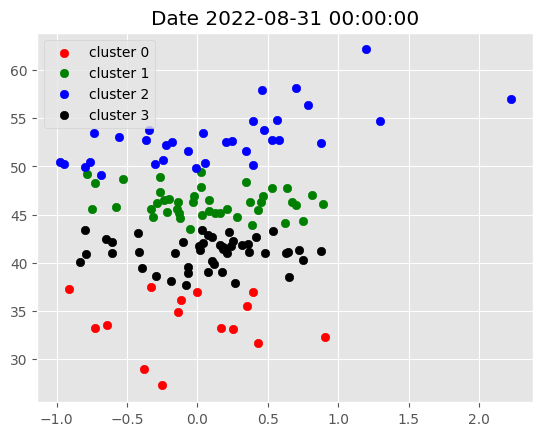

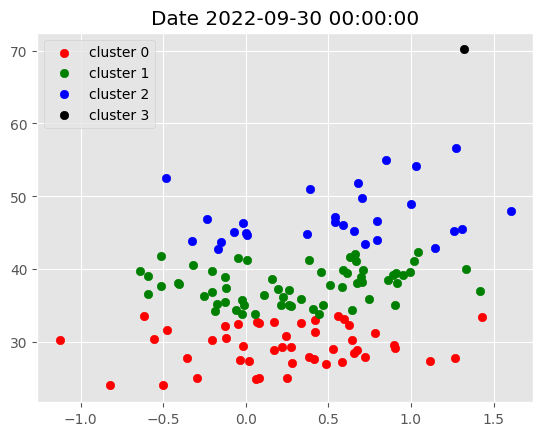

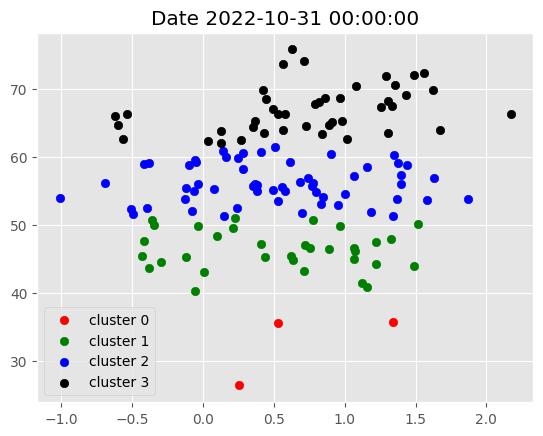

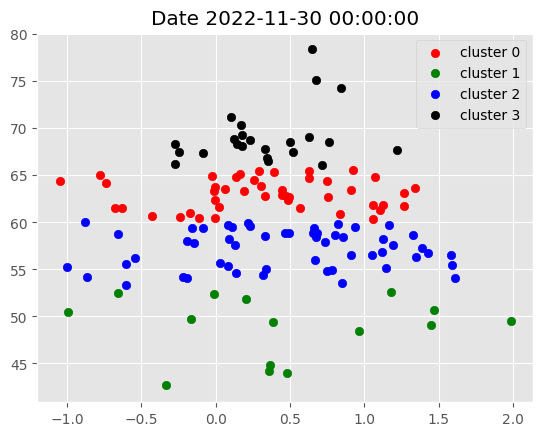

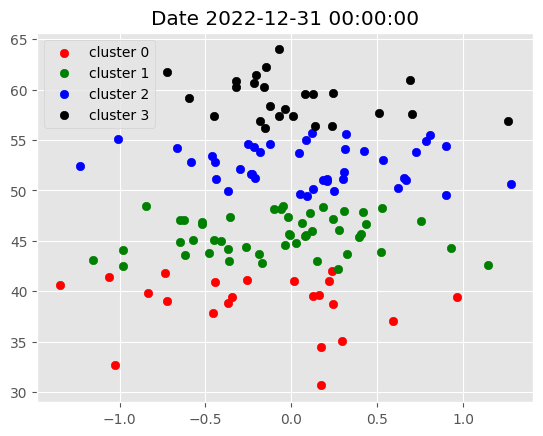

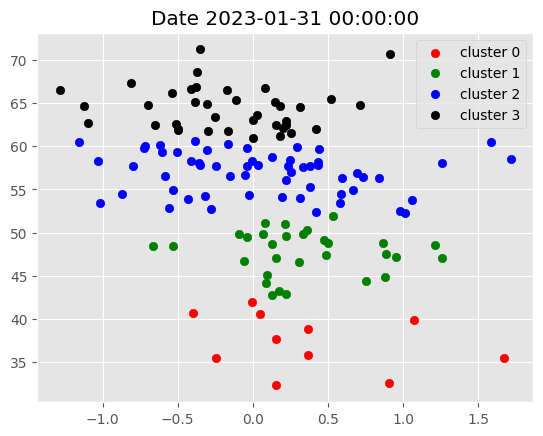

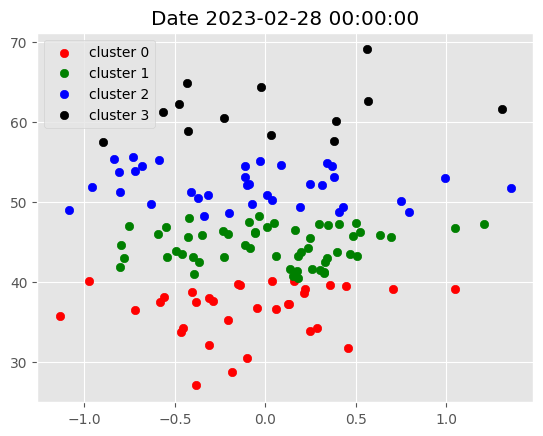

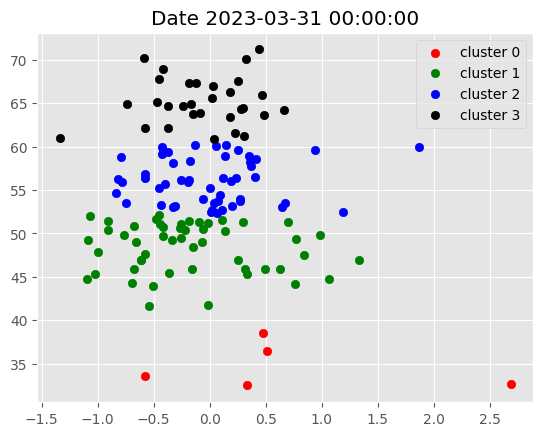

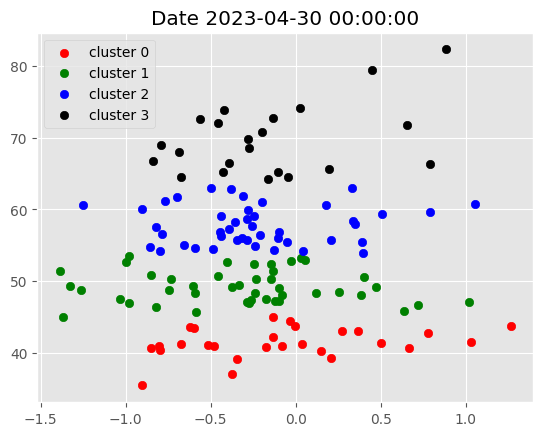

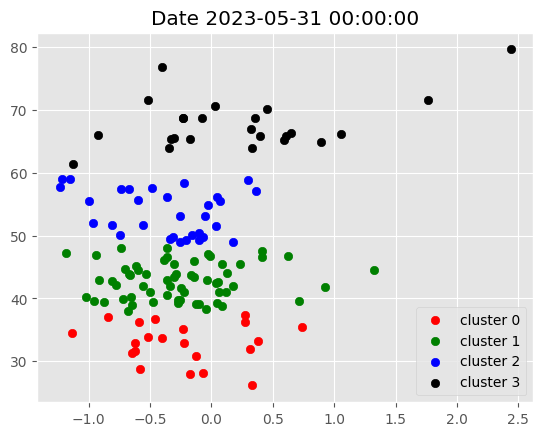

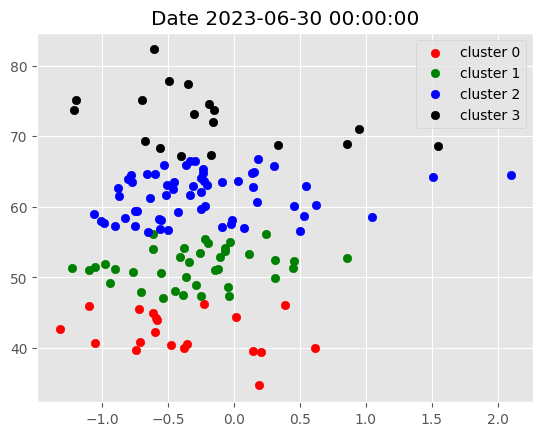

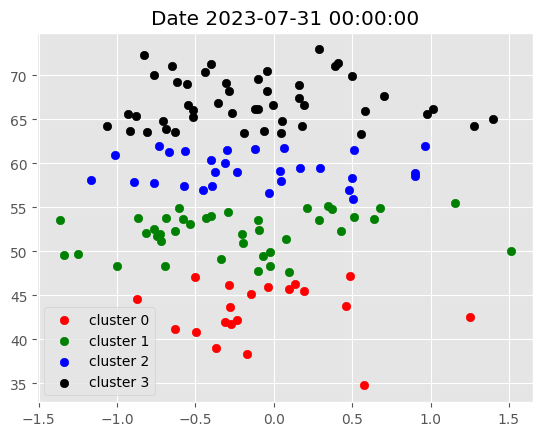

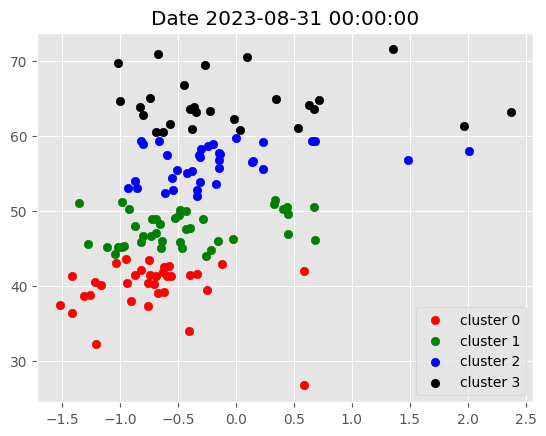

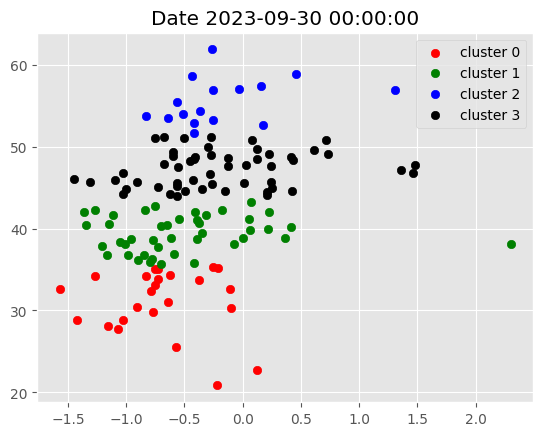

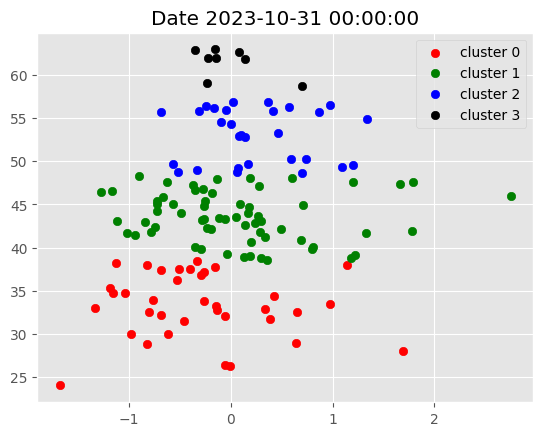

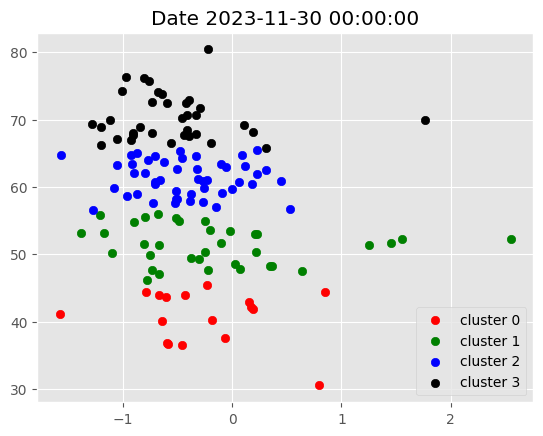

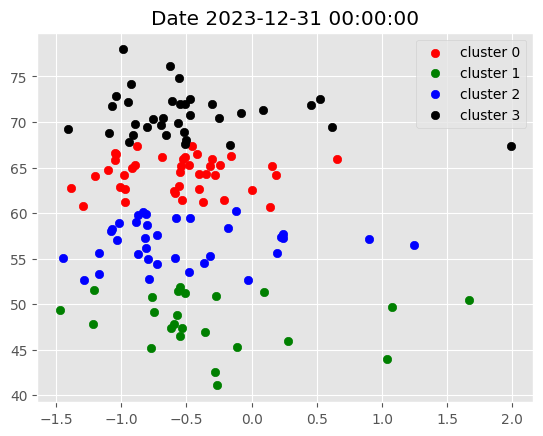

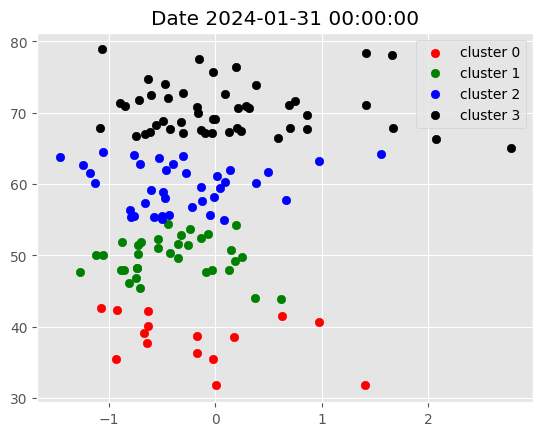

In [15]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

## 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [16]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-03-01': ['AMAT',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CVX',
  'DAL',
  'DE',
  'EL',
  'EXPE',
  'F',
  'GE',
  'GS',
  'JPM',
  'LLY',
  'MPC',
  'MS',
  'MU',
  'OXY',
  'SBUX',
  'SCHW',
  'SLB',
  'UAL',
  'WFC',
  'XOM'],
 '2021-04-01': ['ACN',
  'ADP',
  'AMAT',
  'AMT',
  'BAC',
  'CAT',
  'CI',
  'CSCO',
  'DE',
  'ELV',
  'FDX',
  'HD',
  'HUM',
  'IBM',
  'LIN',
  'LMT',
  'LOW',
  'MCD',
  'MMM',
  'MO',
  'NOC',
  'PG',
  'TGT',
  'TXN',
  'UNH',
  'UPS'],
 '2021-05-01': ['ACN',
  'AMT',
  'AMZN',
  'BLK',
  'BRK-B',
  'BSX',
  'CHTR',
  'DHR',
  'EL',
  'ELV',
  'GOOG',
  'GOOGL',
  'HD',
  'HUM',
  'IBM',
  'ISRG',
  'MCD',
  'MDLZ',
  'MDT',
  'META',
  'NOC',
  'PFE',
  'PM',
  'RTX',
  'SHW',
  'SPGI',
  'T',
  'TGT',
  'UNH',
  'UPS',
  'V',
  'WFC'],
 '2021-06-01': ['AMT',
  'AXP',
  'BLK',
  'BRK-B',
  'C',
  'CRM',
  'CVS',
  'ELV',
  'F',
  'FDX',
  'GS',
  'INTU',
  'JPM',
  'KO',
  'MDLZ',
  'MPC',
  'MRNA',
  'MS',
  'NEM',
  'NVDA',
  'RTX',
  'SCHW',

### Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [17]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [18]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  137 of 137 completed


Price       Adj Close                                                  \
Ticker            AAL        AAPL        ABBV         ABT         ACN   
Date                                                                    
2020-02-28  19.049999   66.651978   71.975403   71.965271  170.531387   
2020-03-02  18.860001   72.857330   74.477882   76.244141  178.992340   
2020-03-03  17.850000   70.543427   73.537361   72.862152  172.070587   
2020-03-04  18.530001   73.815552   77.047531   76.692581  178.340714   
2020-03-05  16.040001   71.421188   76.090210   75.225807  172.391647   
...               ...         ...         ...         ...         ...   
2024-01-24  13.930000  194.252121  164.220001  110.769997  368.899994   
2024-01-25  15.360000  193.922546  165.130005  112.449997  371.940002   
2024-01-26  15.130000  192.174774  164.399994  112.010002  371.070007   
2024-01-29  14.940000  191.485657  163.910004  113.449997  373.350006   
2024-01-30  14.530000  187.800354  164.919998  113.480003  371.299988   

Price                                                                   ...  \
Ticker            ADBE         ADI         ADP        ADSK        AMAT  ...   
Date                                                                    ...   
2020-02-28  345.119995  101.763962  142.247330  190.880005   55.981625  ...   
2020-03-02  360.279999  103.835632  149.840469  190.830002   57.946560  ...   
2020-03-03  348.339996  100.037552  142.706955  180.550003   55.904572  ...   
2020-03-04  363.850006  104.946121  151.118271  191.419998   58.293331  ...   
2020-03-05  351.029999  101.596001  147.698608  184.039993   56.954456  ...   
...                ...         ...         ...         ...         ...  ...   
2024-01-24  606.479980  198.300003  238.440002  252.660004  173.845383  ...   
2024-01-25  622.580017  197.300003  236.720001  251.750000  172.337936  ...   
2024-01-26  613.929993  193.929993  236.100006  253.070007  166.617615  ...   
2024-01-29  630.229980  197.199997  237.710007  257.230011  168.194946  ...   
2024-01-30  627.960022  194.740005  238.589996  256.470001  165.958740  ...   

Price         Volume                                                  \
Ticker          UBER       UNH      UNP       UPS         V     VRTX   
Date                                                                   
2020-02-28  52049300   9961000  7045800  11498000  22659000  2485900   
2020-03-02  46662000   8866300  7064800   8738800  17434500  2406400   
2020-03-03  35182400   9188100  5654000   9263400  15226400  2092900   
2020-03-04  44738600  14533000  4415000   6644800  10789100  1971800   
2020-03-05  32764500   5908400  4901900   5277200  10106900  1518300   
...              ...       ...      ...       ...       ...      ...   
2024-01-24  17238100   2918800  2843400   3187600   5021700  1670900   
2024-01-25  21963000  14671000  4154600   4070000   6894900  1230600   
2024-01-26  13099600   6212200  2493400   2818200   8586500   944500   
2024-01-29  15902000   4554100  2844600   5459700   6574500  1004100   
2024-01-30  17562100   4931200  2435400  16983600   6549000  3329900   

Price                                               
Ticker            VZ       WFC       WMT       XOM  
Date                                                
2020-02-28  45828300  71703000  52369200  62446700  
2020-03-02  30736200  44231200  51222600  38127600  
2020-03-03  27500200  45091000  33340800  50580700  
2020-03-04  17626400  33881500  24625200  24079600  
2020-03-05  21249900  45037900  25638300  40788200  
...              ...       ...       ...       ...  
2024-01-24  27910400  17776000  22932900  17330600  
2024-01-25  24613200  17979600  16369500  22089500  
2024-01-26  20367200  19211100  15746400  20817200  
2024-01-29  23905700  16725200  18240300  18317500  
2024-01-30  20044600  14736800  15270000  19610900  

[987 rows x 822 columns]

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [19]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2021-03-01,0.024422
2021-03-02,-0.013205
2021-03-03,-0.003425
2021-03-04,-0.017939
2021-03-05,0.028995
...,...
2024-01-24,0.004847
2024-01-25,0.004955
2024-01-26,-0.010726


## 8. Visualize Portfolio returns and compare to SP500 returns.

In [20]:
spy = yf.download(tickers='SPY',
                  start='2021-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2021-03-01,0.024422,0.023951
2021-03-02,-0.013205,-0.007834
2021-03-03,-0.003425,-0.013334
2021-03-04,-0.017939,-0.012452
2021-03-05,0.028995,0.018229
...,...,...
2024-01-24,0.004847,0.001093
2024-01-25,0.004955,0.005424
2024-01-26,-0.010726,-0.001271
2024-01-29,0.011553,0.007888


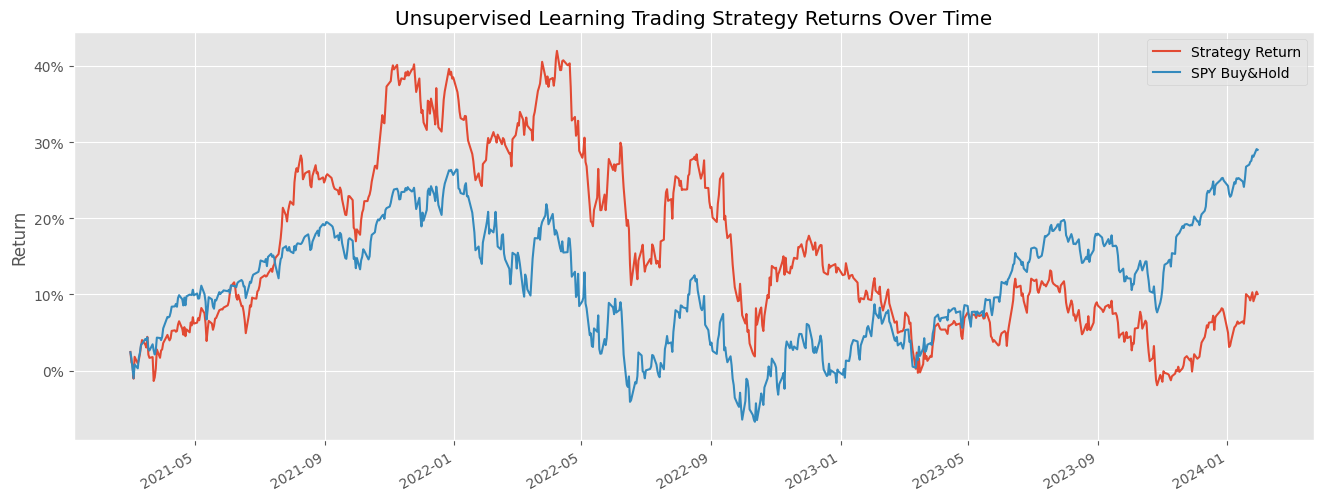

In [21]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-01-31'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()


# Twitter Sentiment Investing Strategy

## 1. Load Twitter Sentiment Data

* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os
plt.style.use('ggplot')

data_folder = '.'

sentiment_df = pd.read_csv(os.path.join(data_folder, 'sentiment_data.csv'))
sentiment_df


,date,symbol,twitterPosts,twitterComments,twitterLikes,twitterImpressions,twitterSentiment
0,2021-11-18,AAPL,811.0,2592.0,21674.0,7981808.0,NaN
1,2021-11-18,ABT,21.0,3.0,13.0,64089.0,NaN
2,2021-11-18,AMD,150.0,675.0,2949.0,1645270.0,NaN
3,2021-11-18,AMZN,557.0,1315.0,12969.0,5590695.0,NaN
4,2021-11-18,ATVI,82.0,36.0,131.0,1310715.0,NaN
...,...,...,...,...,...,...,...
27230,2023-01-04,TMO,21.0,2.0,32.0,30857.0,0.610020
27231,2023-01-04,TSLA,6767.0,540711.0,3810688.0,55464921.0,0.543057
27232,2023-01-04,TSN,35.0,168.0,460.0,57207.0,0.561900
27233,2023-01-04,V,132.0,1008.0,5943.0,139835.0,0.567286


In [23]:
# ATVI is not available now
sentiment_df = sentiment_df.drop(sentiment_df[sentiment_df.symbol == 'ATVI'].index)

In [24]:
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           BA              61.0             55.0         342.0   
           CRM             25.0           7183.0       29832.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           BA                425847.0               NaN          0.160819  
           CRM               142826.0               NaN          0.240782  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[24994 rows x 6 columns]

## 2. Aggregate Monthly and calculate average sentiment for the month

* Aggregate on a monthly level and calculate average monthly metric, for the one we choose.

In [25]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  71.0
           TSN             0.280553  30.0
           V               0.194045  59.0
           XOM             0.217904  52.0

[1094 rows x 2 columns]

## 3. Select Top 5 Stocks based on their cross-sectional ranking for each month

* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.

In [26]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

## 4. Extract the stocks to form portfolios with at the start of each new month

* Create a dictionary containing start of month and corresponded selected stocks.

In [27]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

## 5. Download fresh stock prices for only selected/shortlisted stocks

In [28]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()

prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

[*********************100%%**********************]  84 of 84 completed


In [29]:
prices_df

Price        Adj Close                                                         \
Ticker               A    AAL         AAP        AAPL        ABBV         ABT   
Date                                                                            
2021-01-04  116.384743  15.13  145.845093  127.002090   92.173615  103.105186   
2021-01-05  117.336311  15.43  145.687531  128.572327   93.126755  104.380890   
2021-01-06  120.553955  15.52  154.104156  124.244377   92.322273  104.163544   
2021-01-07  123.761803  15.38  155.420410  128.484009   93.310371  105.174667   
2021-01-08  124.644691  15.13  157.635788  129.592957   93.800056  105.467606   
...                ...    ...         ...         ...         ...         ...   
2023-02-22  141.055115  15.56  140.077362  148.119385  144.812668  100.645615   
2023-02-23  142.167038  15.87  138.507095  148.606781  146.158234  100.508400   
2023-02-24  140.181458  15.56  135.425034  145.931076  146.773361   98.459999   
2023-02-27  141.154373  15.63  137.161133  147.134628  148.282318   97.783730   
2023-02-28  140.945908  15.98  141.384338  146.627350  147.917084   99.694916   

Price                                                    ...   Volume  \
Ticker            AEP        AES         ALB        AMD  ...      RCL   
Date                                                     ...            
2021-01-04  72.294289  21.144056  149.119385  92.300003  ...  5732800   
2021-01-05  72.196762  21.853714  159.182449  92.769997  ...  4029500   
2021-01-06  72.773071  22.727131  171.072556  90.330002  ...  3612500   
2021-01-07  70.831367  22.499680  179.767838  95.160004  ...  3993700   
2021-01-08  70.201889  23.127451  179.865540  94.580002  ...  3104200   
...               ...        ...         ...        ...  ...      ...   
2023-02-22  87.072273  24.488310  244.324448  76.610001  ...  2044600   
2023-02-23  86.966820  24.488310  251.660629  79.750000  ...  2066600   
2023-02-24  86.698357  24.420795  247.367981  78.089996  ...  2875100   
2023-02-27  86.353218  23.996422  254.803268  78.769997  ...  2459700   
2023-02-28  84.339882  23.803524  252.116669  78.580002  ...  3662300   

Price                                                                          \
Ticker         REGN       SLB      STZ         T      TMO       TSLA      TSN   
Date                                                                            
2021-01-04   911100   8743400  1202600  86700816  2220400  145914600  2177400   
2021-01-05   797700  16256600  1530200  83054520  2046700   96735600  2297100   
2021-01-06  1434700  19456300  1861700  73455520  2112300  134100000  1942200   
2021-01-07  1126600  14502400  2537100  71265359  2144400  154496700  2969400   
2021-01-08  1018800  11951900  1595400  72471656  2221700  225166500  2672400   
...             ...       ...      ...       ...      ...        ...      ...   
2023-02-22   415500   9181100  1092200  25308800  1705300  191828500  4217700   
2023-02-23   553300   6324500   979700  24845800  1160200  146360000  3403500   
2023-02-24   525900   8458700   702900  29138100   852600  142228100  2439300   
2023-02-27   557100   6287000   608200  22981100  1110600  161028300  3922200   
2023-02-28   622700  10634200  1136900  34154800  1188800  153144900  3556300   

Price                           
Ticker             V       XOM  
Date                            
2021-01-04  10318300  27764700  
2021-01-05   6869700  44035100  
2021-01-06   7206200  36484800  
2021-01-07  10967900  29528100  
2021-01-08   6513000  28628200  
...              ...       ...  
2023-02-22   4621800  13973800  
2023-02-23   5533800  11289400  
2023-02-24   4414400  14351000  
2023-02-27   4255300  11710500  
2023-02-28   5385400  18107000  

[542 rows x 504 columns]

## 6. Calculate Portfolio Returns with monthly rebalancing


In [30]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')
    
    cols = fixed_dates[start_date]
    
    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')
    
    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
portfolio_df

,portfolio_return
Date,
2021-12-01,-0.016417
2021-12-02,0.024872
2021-12-03,-0.007711
2021-12-06,0.023926
2021-12-07,0.030547
...,...
2023-02-22,-0.007870
2023-02-23,-0.007323
2023-02-24,-0.009463


## 7. Download NASDAQ/QQQ prices and calculate returns to compare to our strategy

In [31]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,portfolio_return,nasdaq_return
Date,,
2021-12-01,-0.016417,-0.017159
2021-12-02,0.024872,0.007181
2021-12-03,-0.007711,-0.017541
2021-12-06,0.023926,0.007981
2021-12-07,0.030547,0.029669
...,...,...
2023-02-22,-0.007870,0.000748
2023-02-23,-0.007323,0.008696
2023-02-24,-0.009463,-0.016886


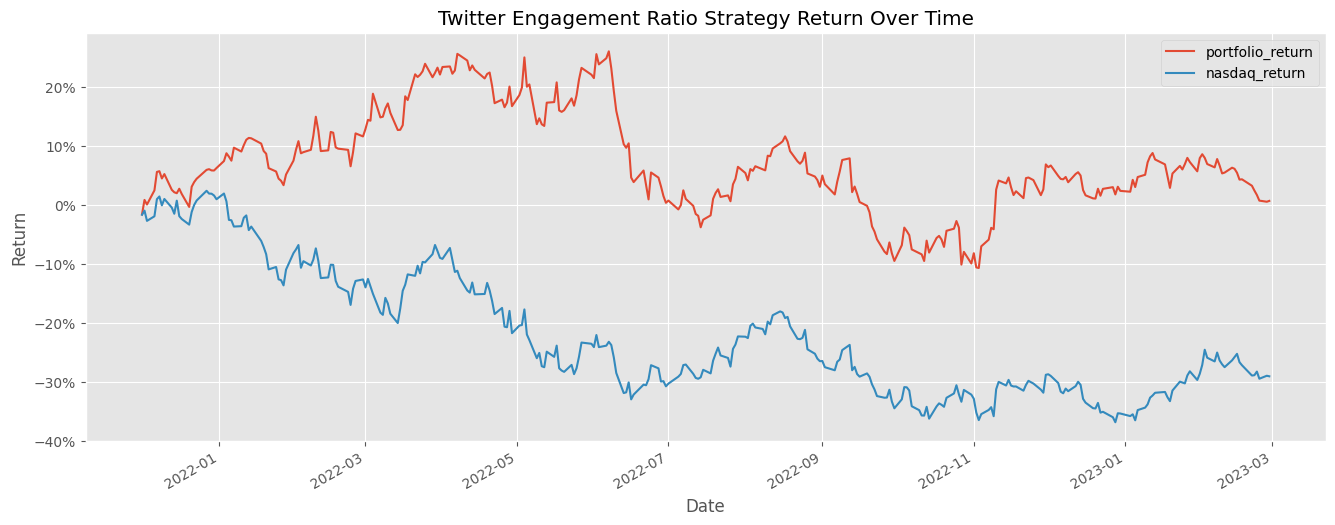

In [32]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.

## 1. Load Simulated Daily and Simulated 5-minute data.

* We are loading both datasets, set the indexes and calculate daily log returns.

In [41]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas_ta
import pandas as pd
import numpy as np
import os

In [42]:


data_folder = '.'

daily_df = pd.read_csv(os.path.join(data_folder, 'simulated_daily_data.csv'))

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')


intraday_5min_df = pd.read_csv(os.path.join(data_folder, 'simulated_5min_data.csv'))

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

,open,low,high,close,volume,date
datetime,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,2021-09-29
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,2021-09-29
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,2021-09-29
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,2021-09-29
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,2021-09-29
...,...,...,...,...,...,...
2023-09-20 10:40:00,6792.1025,6783.6000,6796.2500,6790.1375,41,2023-09-20
2023-09-20 10:45:00,6790.5575,6779.1000,6795.7500,6781.9175,42,2023-09-20
2023-09-20 10:50:00,6781.5475,6779.3750,6790.2500,6783.9050,44,2023-09-20


## 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.

* We are first calculating the 6-month rolling variance and then we are creating a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [44]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    # print(x.index[-1])
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

/home/msjithin/Quant_sandbox/.quant/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/msjithin/Quant_sandbox/.quant/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/msjithin/Quant_sandbox/.quant/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/home/msjithin/Quant_sandbox/.quant/lib/python3.9/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional 

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions
Date,,,,,,,,,
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703
2020-07-03,2281.210693,2300.586182,2264.698730,2271.825928,2271.825928,1.307897e+10,-0.003965,0.002456,0.000704
...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286


## 3. Calculate prediction premium and form a daily signal from it.

* We are calculating the prediction premium. And calculate its 6-month rolling standard deviation.

* From this we are creating our daily signal.

In [45]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

,Open,High,Low,Close,Adj Close,Volume,log_ret,variance,predictions,prediction_premium,premium_std,signal_daily
Date,,,,,,,,,,,,
2020-06-29,2285.007324,2309.393311,2260.468994,2297.713623,2297.713623,1.646055e+10,0.005157,0.002473,0.000651,-0.736678,NaN,NaN
2020-06-30,2296.395264,2304.458984,2271.209473,2284.498291,2284.498291,1.573580e+10,-0.005768,0.002468,0.000877,-0.644671,NaN,NaN
2020-07-01,2286.496338,2327.438721,2276.183838,2307.081299,2307.081299,1.597155e+10,0.009837,0.002455,0.000618,-0.748362,NaN,NaN
2020-07-02,2307.784912,2318.740723,2259.155762,2280.852539,2280.852539,1.633892e+10,-0.011434,0.002456,0.000703,-0.713818,NaN,NaN
2020-07-03,2281.210693,2300.586182,2264.698730,2271.825928,2271.825928,1.307897e+10,-0.003965,0.002456,0.000704,-0.713487,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,0.011801,0.000393,0.000334,-0.151792,0.549073,NaN
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,0.002597,0.000385,0.000292,-0.240810,0.546370,NaN
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,-0.001520,0.000384,0.000286,-0.256793,0.545350,NaN


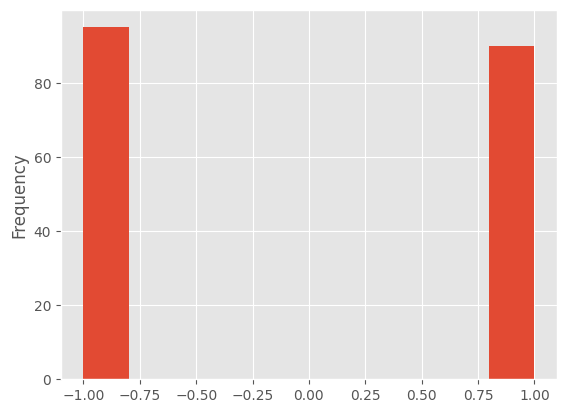

In [46]:
plt.style.use('ggplot')

daily_df['signal_daily'].plot(kind='hist')

plt.show()

## 4. Merge with intraday data and calculate intraday indicators to form the intraday signal.

* Calculate all intraday indicators and intraday signal.

In [47]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

,open,low,high,close,volume,signal_daily,rsi,lband,uband,signal_intraday,return
datetime,,,,,,,,,,,
2021-09-29 20:00:00,10379.7775,10364.5950,10398.7025,10370.9575,46,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-29 20:05:00,10370.9425,10352.4175,10380.2500,10371.1450,53,NaN,NaN,NaN,NaN,NaN,0.000018
2021-09-29 20:10:00,10372.8150,10357.8250,10388.7500,10384.3125,116,NaN,NaN,NaN,NaN,NaN,0.001269
2021-09-29 20:15:00,10385.8275,10384.0825,10457.2000,10442.5175,266,NaN,NaN,NaN,NaN,NaN,0.005589
2021-09-29 20:20:00,10442.5225,10426.2375,10448.0000,10440.9950,65,NaN,NaN,NaN,NaN,NaN,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-18 23:35:00,6708.0025,6705.5175,6712.0000,6708.8675,11,NaN,62.861699,6677.365065,6715.855435,NaN,0.000128
2023-09-18 23:40:00,6708.8650,6707.1800,6714.2500,6709.3350,22,NaN,63.165869,6679.544207,6716.559793,NaN,0.000070
2023-09-18 23:45:00,6709.9250,6704.3600,6713.5000,6708.2750,25,NaN,61.954798,6682.379916,6716.534084,NaN,-0.000158


## 5. Generate the position entry and hold until the end of the day.

In [48]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

## 6. Calculate final strategy returns.

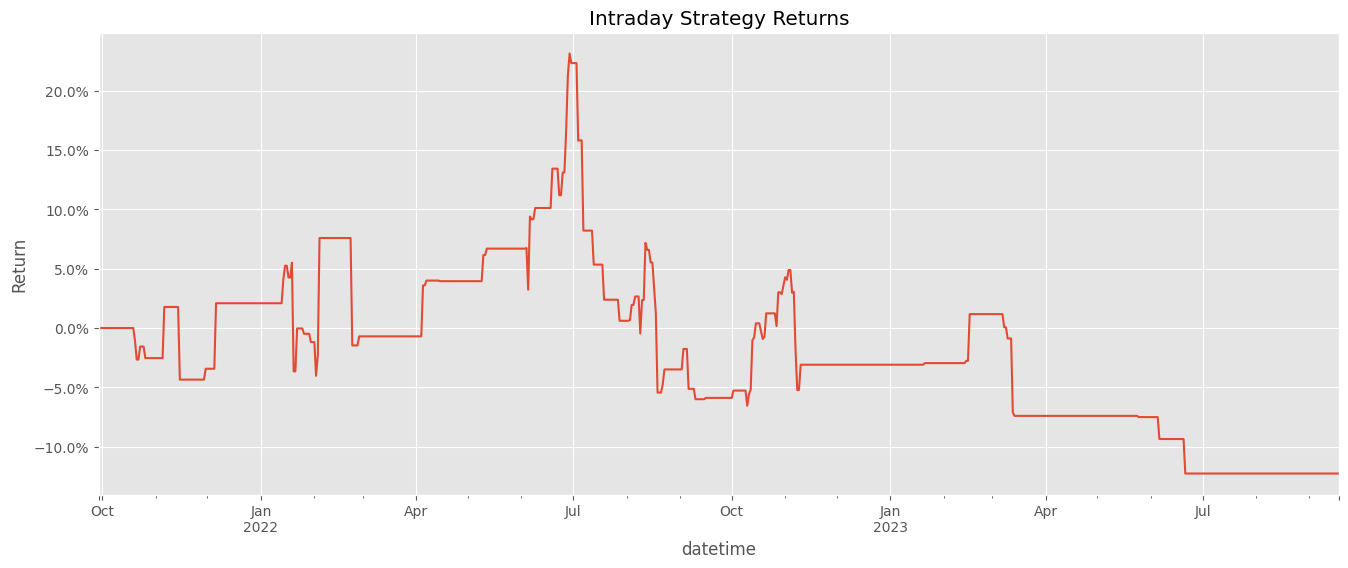

In [49]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()
                                                                            